In [1]:
import sys
sys.path.insert(1, '/home/hehao057/6411/')

In [2]:
from model.retina import Retina_Net_multi_head
from model.helper import *

from fastai.vision import *
from fastai.vision.models.unet import model_sizes

In [3]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

[PosixPath('/home/hehao057/.fastai/data/pascal_2007/segmentation'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/test.csv'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/train.csv'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/train.json'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/test'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/models'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/test.json'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/train'),
 PosixPath('/home/hehao057/.fastai/data/pascal_2007/valid.json')]

In [4]:
train_images, train_lbl_bbox = get_annotations(path/'train.json')
val_images, val_lbl_bbox = get_annotations(path/'valid.json')
images, lbl_bbox = train_images+val_images,train_lbl_bbox+val_lbl_bbox
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [5]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'train')
    src = src.split_by_files(val_images)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True,resize_method=ResizeMethod.SQUISH)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate,num_workers=8).normalize(imagenet_stats)

/home/hehao057/fastai1/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)
/home/hehao057/fastai1/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


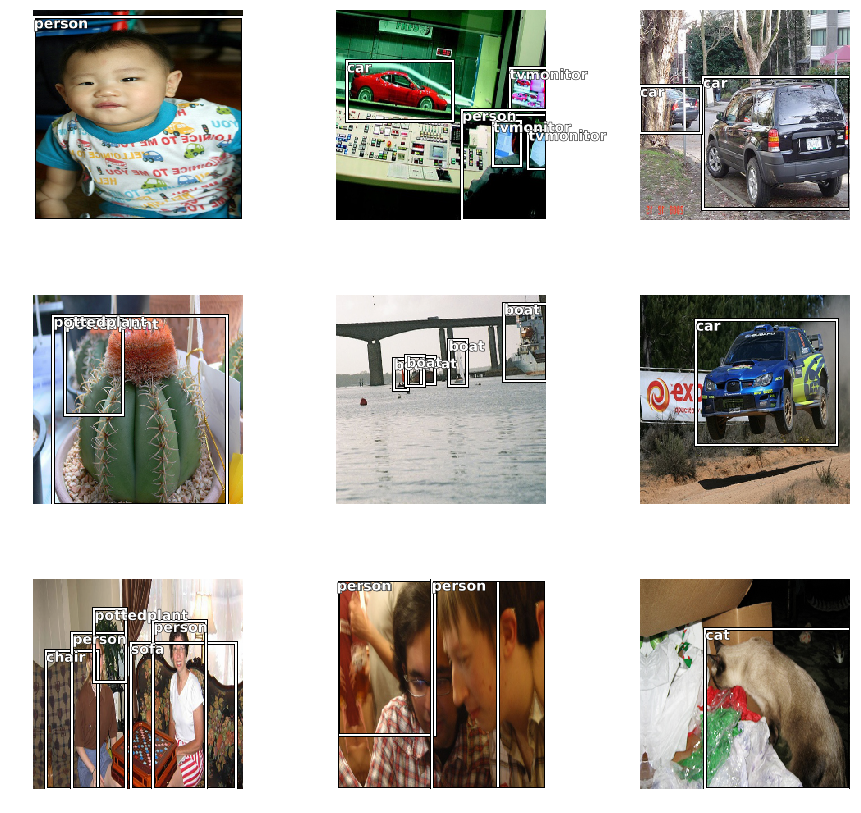

In [6]:
data = get_data(64,256)
data.show_batch(rows=3)

# Create Anchor (proposal box)

In [14]:
encoder = create_body(models.resnet50,cut=-2)
model_sizes(encoder, size=(256,256))

[torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 64, 64, 64]),
 torch.Size([1, 256, 64, 64]),
 torch.Size([1, 512, 32, 32]),
 torch.Size([1, 1024, 16, 16]),
 torch.Size([1, 2048, 8, 8])]

In [15]:
anc_grids = [32,16,8,4,2] # change according to the last 3, aka 32, 16, 8
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()

# Define loss

In [16]:
def get_weight(x,t):
    x,t = x.cpu(),t.cpu()
    alpha,gamma = 0.25,2
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
    
def bceloss(pred,target,num_classes,focal_loss=False):
    #print(target.shape)
    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    #print(t.shape,p.shape)
    w = get_weight(p,t) if focal_loss else None
    return F.binary_cross_entropy_with_logits(p.cpu(),t,weight=w.detach(),reduction='sum') / (num_classes-1)

def single_Loss(pbox,plabel,box,label):
    #handle ground truth object, from any shape to feature map size
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) #iou take both inputs in fastai style
    bbox,clas = un_pad(box,label) #y from databunch already in fastai style
    overlaps = iou(bbox,base_box.cuda())
    try:
        gt_overlaps,gt_idx = map_to_gt(overlaps)
    except:
        return 0,0
    #map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]
    pos = gt_overlaps > 0.4
    gt_clas[~pos] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_clas.detach()] #vector of size of # of bbox
    pos_idx = torch.nonzero(pos)[:,0] #for which cells that gt bbox exists
    gt_bbox = bbox[gt_idx]
    
    #map pred bounding box to anchor, final box = pred box + anchor box
    p_final_box = act_to_bbox(pbox,anchor_box.cuda(),grid_sizes) #grid size over # of anchor box along single axis
    
    
    #cal loss
    #L1loss
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),data.c,focal_loss=True)
    return loc_loss,label_loss

def focal_loss(preds,*targets,print_it=False):
    batch_loc_loss,batch_label_loss = 0., 0.
    for p_box,p_label,box,label in zip(*preds,*targets):
        loc_loss,label_loss = single_Loss(p_box,p_label,box,label)
        batch_loc_loss = batch_loc_loss + loc_loss
        batch_label_loss = batch_label_loss + label_loss
    total_loss = batch_loc_loss + batch_label_loss.cuda()
    if print_it: print(batch_loc_loss,batch_label_loss)
    return total_loss

In [17]:
encoder = create_body(models.resnet50,cut=-2)

In [18]:
loss_func = focal_loss
retina_net = Retina_Net_multi_head(encoder,data.c,img_size=256)

In [19]:
learn = Learner(data,retina_net.cuda(),loss_func=loss_func)

In [21]:
x, y = learn.data.one_batch()

In [30]:
preds = learn.model(x.cuda())

In [32]:
preds[0].shape,preds[1].shape

(torch.Size([64, 12276, 4]), torch.Size([64, 12276, 21]))

In [43]:
nms_box = NMS(preds[0].cpu().detach().numpy())

In [51]:
nms_box[0][4000]

array([-1,  0, -2,  0])

In [55]:
preds[0][0][1000].cpu().detach()

tensor([-1.1177, -1.5427,  2.0866, -0.2062])

In [57]:
idx = 0
t_bbox,t_clas = un_pad(y[0][idx],y[1][idx])

In [63]:
final_box = act_to_bbox(preds[0][idx].cpu(),anchors,grid_sizes)

In [65]:
idx_clas = preds[1][idx][:,1:].max(dim=1)[0].sigmoid() > 0.1

In [67]:
fina_box = final_box.cuda().index_select(dim=0,index=idx_clas.nonzero().squeeze())

In [74]:
final_box = ImageBBox.create(256,256, final_box.cpu().detach().numpy(),scale=False).data

In [86]:
def _unscale_pnts(y, sz): return TensorPoint((y+1) * tensor(sz).float()/2, img_size=sz)

In [87]:
_unscale_pnts(final_box.view(-1,2),256)

NameError: name 'cast' is not defined

In [20]:
learn.split(lambda m: (m.encoder[6],m.c5top5));
learn.to_fp16();

In [21]:
learn.freeze_to(-1);

In [22]:
lr = 1e-4
learn.fit_one_cycle(3,slice(lr))

epoch,train_loss,valid_loss,time
0,221137.156250,4615.358887,20:02


KeyboardInterrupt: 

# To be tested

In [41]:
treshold = 0.6
def NMS(boxes, overlapThresh = 0.4):
    #return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We have a least a box of one pixel, therefore the +1
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        temp_indices = indices[indices!=i]
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        if np.any(overlap) > treshold:
            indices = indices[indices != i]
    return boxes[indices].astype(int)

In [18]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 